In [80]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [81]:
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BloodPressure_0,SkinThickness_0,Insulin_0,SkinThickness_na,BloodPressure_na,Insulin_na,SkinThickness_mean,BloodPressure_mean,Insulin_mean,Pregnancies_bin
0,200,9,125,74,0,0,28.536910,0.444902,45,1.0,74.0,NaN,NaN,1,0,1,26.875,74.0,135.636364,10
1,3832,4,109,80,0,0,28.047673,0.238243,22,0.0,80.0,NaN,NaN,1,0,1,26.875,80.0,135.636364,6
2,4927,4,88,78,39,0,52.371341,0.279471,26,0.0,78.0,39.0,NaN,0,0,1,39.000,78.0,135.636364,6
3,4088,9,125,74,0,0,40.062688,0.203922,45,0.0,74.0,NaN,NaN,1,0,1,26.875,74.0,135.636364,10
4,3644,5,107,78,44,284,52.935068,0.284959,45,1.0,78.0,44.0,284.0,0,0,0,44.000,78.0,284.000000,6


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   float64
 10  BloodPressure_0           2887 non-null   float64
 11  SkinThickness_0           1234 non-null   float64
 12  Insulin_0                 256 non-null    float64
 13  SkinThickness_na          3000 non-null   int64  
 14  BloodPre

In [83]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BloodPressure_0,SkinThickness_0,Insulin_0,SkinThickness_na,BloodPressure_na,Insulin_na,SkinThickness_mean,BloodPressure_mean,Insulin_mean,Pregnancies_bin
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2887.000000,1234.000000,256.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.408959,0.400476,28.932000,0.239000,71.434361,27.141005,136.679688,0.588667,0.037667,0.914667,26.984417,71.433414,135.725394,5.594000
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,6.990180,0.274666,8.469078,0.426544,9.215697,8.182799,82.032125,0.492157,0.190421,0.279424,5.248441,9.040411,23.922032,2.857951
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,7.748040,0.145844,21.000000,0.000000,46.000000,7.000000,15.000000,0.000000,0.000000,0.000000,7.000000,46.000000,15.000000,3.000000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000,64.000000,19.000000,79.250000,0.000000,0.000000,1.000000,26.875000,64.000000,135.636364,3.000000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000,70.000000,28.000000,126.000000,1.000000,0.000000,1.000000,26.875000,71.409223,135.636364,6.000000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000,78.000000,33.000000,180.000000,1.000000,0.000000,1.000000,26.875000,78.000000,135.636364,10.000000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000,110.000000,49.000000,579.000000,1.000000,1.000000,1.000000,49.000000,110.000000,579.000000,10.000000


In [122]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'SkinThickness',
                 'Insulin',
                 'BloodPressure',
                 
                 
                
                 
             ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [123]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'SkinThickness', 'Insulin', 'BloodPressure'],
      dtype='object')

In [124]:
print(X_train.shape, y_train.shape, id_train.shape)

(3000, 8) (3000, 1) (3000, 1)


ベースライン評価のため一部データを分ける。

残りのデータでvalidationしてその条件・目的変数・validation方法・評価指標を仮定し評価する。

上記3項目を明確にすることをベースラインの決定とする。

validationした後にベースライン評価のためのデータで評価しベースラインを検証する。

validation時とベースライン検証時の結果の傾向に大きな差が無ければベースラインの3項目は問題ないと判断する。

ベースラインが決定すると、その後EDAやモデル改善後はvalidationのみを行い進めていく。
（変更点や結果を記録）

## validation方法（ベースライン作成へ）

clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_test, y_test))

In [125]:
random_state = 123
params = {'random_state': random_state,
          'criterion': 'gini',
          'min_samples_split': 2,
          'min_samples_leaf': 1,
          'verbose': 1
    }

#https://qiita.com/FujiedaTaro/items/61ded4ea5643a6204317#

In [126]:
# cvでの評価用
def train_rf(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = RandomForestClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                )
        # モデルの保存
        fname_rf = 'model/rf/model_rf_fold{}.pickle'.format(nfold)
        with open(fname_rf, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0).astype(int))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0).astype(int))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [127]:
train_oof, imp, metrics = train_rf(X_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[accuracy] tr: 1.00, va: 0.808333
-------------------- 1 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[accuracy] tr: 1.00, va: 0.791667
-------------------- 2 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[accuracy] tr: 1.00, va: 0.783333
-------------------- 3 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[accuracy] tr: 1.00, va: 0.816667
-------------------- 4 --------------------
(2400, 8) (2400, 1)
(600, 8) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[accuracy] tr: 1.00, va: 0.800000
-------------------- result --------------------
[[0.         1.         0.80833333]
 [1.         1.         0.79166667]
 [2.         1.         0.78333333]
 [3.         1.         0.81666667]
 [4.         1.         0.8       ]]
[cv] tr: 1.00+-0.00, va: 0.80
[oof] 0.8000
Done


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [128]:
imp.sort_values('imp', ascending=False)

,col,imp,imp_std
1,BMI,0.224076,0.002374
3,DiabetesPedigreeFunction,0.169789,0.003956
0,Age,0.161527,0.008497
4,Glucose,0.140269,0.001587
2,BloodPressure,0.108337,0.002303
6,Pregnancies,0.105064,0.004159
7,SkinThickness,0.064911,0.002735
5,Insulin,0.026027,0.001060


In [129]:
train_oof

,index,pred
0,200,0.52
1,3832,0.09
2,4927,0.48
3,4088,0.60
4,3644,0.88
...,...,...
2995,4931,0.22
2996,3264,0.01
2997,1653,0.27
2998,2607,0.50


###

'DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'BloodPressure_na', 'BloodPressure_0', 'SkinThickness', 'Insulin_0' 'Insulin_na' 
       
       
'SkinThickness_na' or 'SkinThickness'
###

In [130]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'SkinThickness', 'Insulin', 'BloodPressure'],
      dtype='object')

## 推論

In [131]:
def predict_rf(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_rf = 'model/rf/model_rf_fold{}.pickle'.format(nfold)
        with open(fname_rf, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [132]:
test_pred_proba = predict_rf(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [133]:
test_pred_proba[:3]

,index,pred
0,398,0.282
1,3833,0.082
2,4836,0.040


In [134]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [135]:
train_oof[:3]

,index,pred
0,200,0.52
1,3832,0.09
2,4927,0.48


In [136]:
test_pred.to_csv('sub/submission_rf.csv', index=None, header=False,)

## アンサンブル用データ

In [137]:
import pickle
 
with open('ensamble/rf_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/rf_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

### 初めに検討し問題なければ、その後はスキップ可能

ベースライン（評価指標や検証法、特徴量選択）の評価を行う

① 検証データの評価値とベースライン評価値のギャップが小さいか確認

② 後分類の傾向が似ているか確認

③ 予測値の分布が似ているか確認

上記3点が問題なければ、ベースラインを決定し、EDAやモデル改善を行う。

In [54]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 6) (2400, 1)
ベースライン検証データ:  (600, 6) (600, 1)
検証データ(train):  (1920, 6) (1920, 1)
検証データ(test):  (480, 6) (480, 1)


In [55]:
#validation結果
model = RandomForestClassifier(**params)
model.fit(x_tr1,
          y_tr1,
         )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(random_state=123, verbose=1)

In [60]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))


[検証データ] acc: 0.7771
[ベースライン検証データ] acc: 0.7783
[検証データ] auc: 0.7557
[ベースライン検証データ] auc: 0.8091


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [57]:
#後分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[341  24]
 [ 83  32]]
[[0.71041667 0.05      ]
 [0.17291667 0.06666667]]
ベースライン検証データ
[[420  37]
 [ 96  47]]
[[0.7        0.06166667]
 [0.16       0.07833333]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


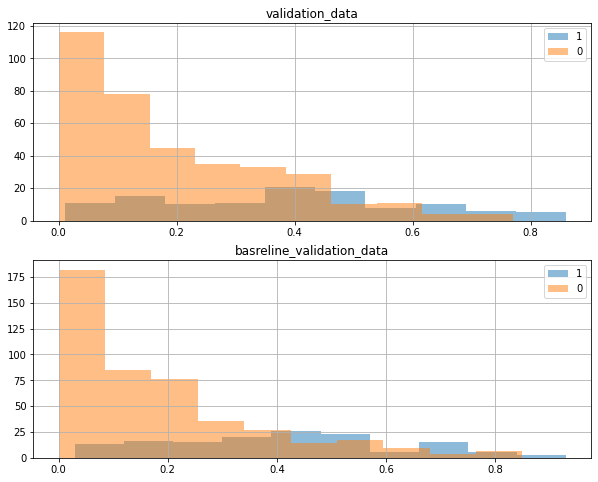

In [58]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()